**Concentratable Entanglement** 

In [1]:
import numpy as np
import math, cmath
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Operator, Statevector

def qiskit_shit(matrix):
    '''Map the operator martrix accross the off-diagonal to make it compatitble with Qiskit
    Example:
        Input:  [[2, 2, 2, 2, 0],
                 [2, 2, 2, 0, 1],
                 [2, 2, 0, 1, 1],
                 [2, 0, 1, 1, 1],
                 [0, 1, 1, 1, 1]]
        Output: [[1, 1, 1, 1, 0],
                 [1, 1, 1, 0, 2],
                 [1, 1, 0, 2, 2],
                 [1, 0, 2, 2, 2],
                 [0, 2, 2, 2, 2]]
    '''

    n = matrix.shape[0]

    # Iterate over the upper triangle of the matrix
    for i in range(n-1):
        for j in range(0, n-i-1):
            # Swap symmetric elements across the off-diagonal
            matrix[i, j], matrix[-j-1, -i-1] = matrix[-j-1, -i-1], matrix[i, j]

    return matrix


def fourier_trans(K, dagger=False):
    '''Get the matrix representation of Fourier transform operator and its inverse
    Args:
        K: number of levels of the qudit
        dagger: Ture -> inverse Fourier transform
                False -> Fourier transform
    Yields: matrix representation of FT and IFT
        
    '''

    L = math.ceil(math.log2(K)) # number of qubits to represent one K-level qudit

    w = cmath.exp(2*cmath.pi*1j/K)
    if dagger:
        w = cmath.exp(-2*cmath.pi*1j/K)

    F_tmp = np.ones((K,K), dtype=complex)
    for i in range(K):
        for j in range(K):
            F_tmp[i,j] = w**(i*j)

    F = 1/(K**0.5)*F_tmp
    I = np.identity(2**L-K)

    return np.block([[F, np.zeros((K,2**L-K))],
                   [np.zeros((2**L-K,K)), I]])


def cyc_determine(m, t_row, t_col, K):
    '''Determine if one binary string can be shifted to another one by m steps
    Args:
        m: index of the basis of the ancilla qudit
        (t_row, t_col): index of element of matrix (in basis of target qubits)
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        value: the value of the element at (t_row, t_col) 
    '''
    # m, t_row, t_col are all decimal integers
    ttt_row = bin(t_row).replace('0b', '') # t'
    ttt_row = ttt_row.zfill(K)
    ttt_col = bin(t_col).replace('0b', '') # t
    ttt_col = ttt_col.zfill(K)

    value = 0
    if ttt_row == ttt_col[m:] + ttt_col[:m]:
        value = 1
    
    return value

def sub_block(m, K):
    '''Get the m-th block matrix of the the matrix representation of the controlled cyclic operator
    Args:
        m: index of the basis of the ancilla qudit
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        block: m-th block matrix
    '''
    block = np.zeros((2**K,2**K))
    for i in range(2**K):
        for j in range(2**K):
            block[i,j] = cyc_determine(m, i, j, K)
            
    return block

def direct_sum(*matrices):
    '''Get the direct sum of all the input square matrices'''
    
    # Get the size of the resulting matrix
    total_size = sum(matrix.shape[0] for matrix in matrices)
    result_matrix = np.zeros((total_size, total_size), dtype=matrices[0].dtype)

    # Populate the block diagonal matrix
    current_row, current_col = 0, 0
    for matrix in matrices:
        size = matrix.shape[0]
        result_matrix[current_row:current_row+size, current_col:current_col+size] = matrix
        current_row += size
        current_col += size

    return result_matrix


# controlled cyclic permutations
def control_cyclic_perm(L, K):
    '''Get the matrix representation of the controlled cyclic operator'''
    
    block_dict = {}

    for m in range(2**L):
        ccc = bin(m).replace('0b', '')
        block_dict[ccc.zfill(L)] = sub_block(m, K)

    return direct_sum(*block_dict.values())

In [2]:
N = 3 # number of qubits of each state |\psi>, also number of qudits required
K = 5 # number of levels of the qudit, also number of copies of state |\psi>
L = math.ceil(math.log2(K)) # number of qubits to represent one K-level qudit

psi_state = Statevector([1/2**0.5, 0, 0, 0, 0, 0, 0, 1/2**0.5]) 

# Name the N ancilla qudits, each of which is encoded by L qubits
ancilla_qudits = {}
for i in range(N):
    qudit_index = f"qudit_{i}"
    ancilla_qudits[qudit_index] = QuantumRegister(L, 'ancilla qudit '+str(i)) 

# Name the N L-bit classical bits, which is for storing the measurement results of the N ancilla qudits
classical_bits = {}
for i in range(N):
    cbit_index = f"cbit_{i}"
    classical_bits[cbit_index] = ClassicalRegister(L, 'classical bit '+str(i)) 

# Name the K copies of each N-qubit state |\psi>
copies = {}
for i in range(K):
    copy_index = f"copy_{i}"
    copies[copy_index] = QuantumRegister(N, 'copy '+str(i)) 

# Define Fourier transform and its inverse operator for qudits
FT = Operator(qiskit_shit(fourier_trans(K, dagger=False))).to_instruction()
FT.label = "   FT  "
FT_dagger = Operator(qiskit_shit(fourier_trans(K, dagger=True))).to_instruction()
FT_dagger.label = "   IFT  "

# Define the qudit-controlled cyclic permutation operator
CCP = Operator(qiskit_shit(control_cyclic_perm(L, K))).to_instruction()
CCP.label = "   CCP  "

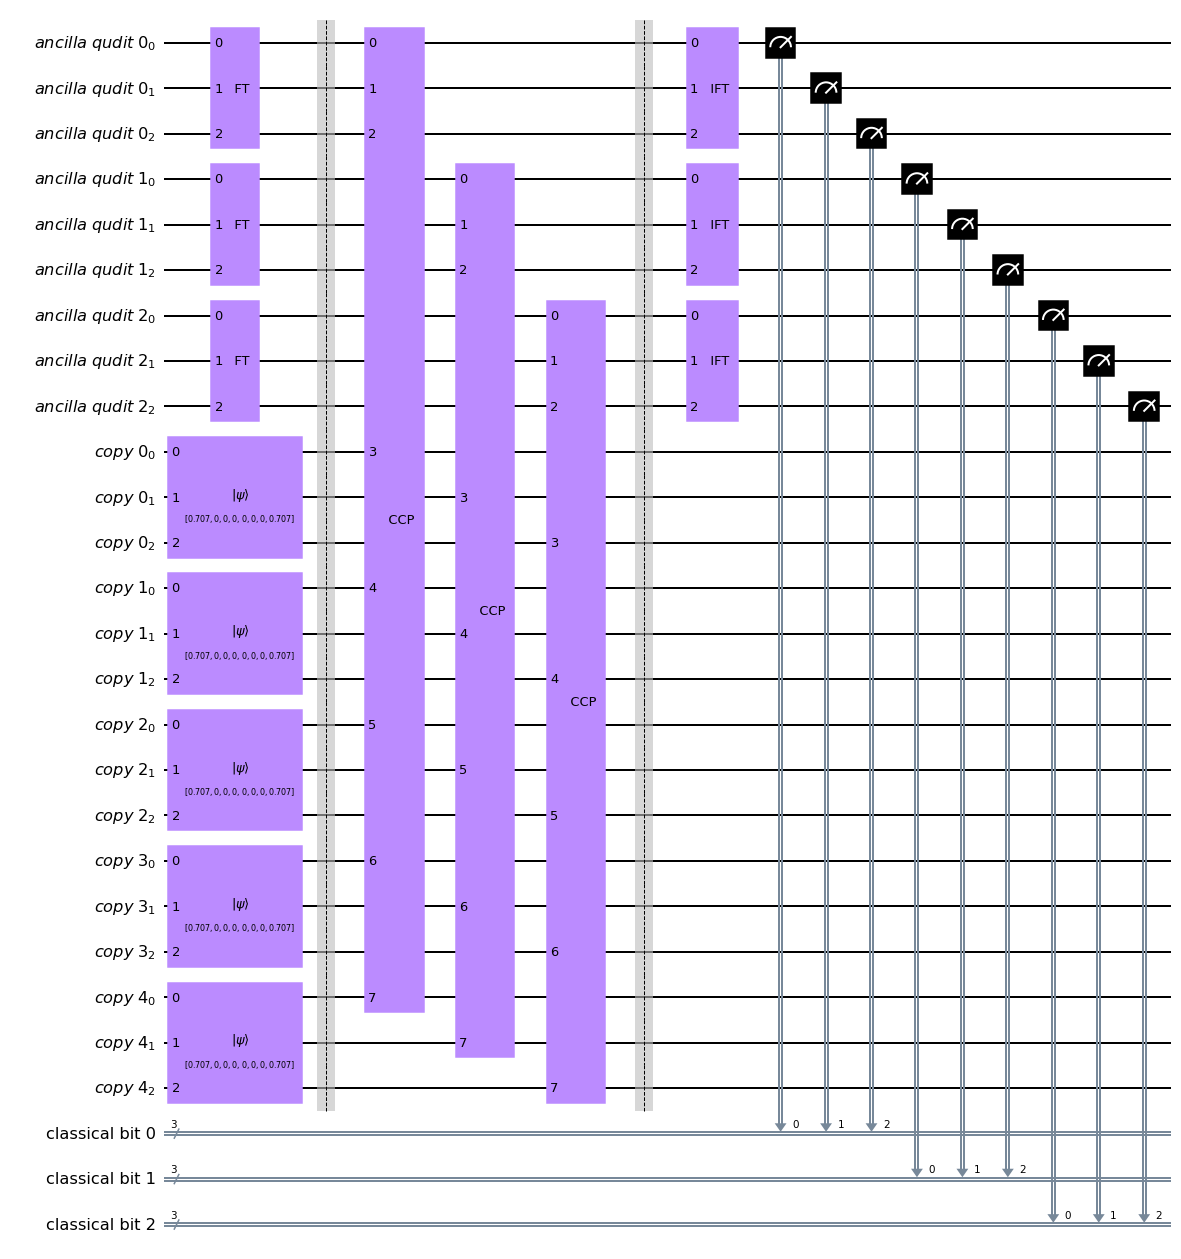

In [3]:
# Write the quantum circuit
qc = QuantumCircuit(*ancilla_qudits.values(), *copies.values(), *classical_bits.values()) 

# Initialize the psi states
for i in range(K):
    qc.initialize(psi_state, copies['copy_'+str(i)])

# Fourier Transform on ancillas
for i in range(N):
    qc.append(FT, ancilla_qudits['qudit_'+str(i)])
qc.barrier(*ancilla_qudits.values(), *copies.values())

# Controlled cyclic permutation operators
for i in range(N):  
    register_index_tmp = []
    for j in range(K):
        register_index_tmp.append(copies['copy_'+str(j)][i])
        register_index = ancilla_qudits['qudit_'+str(i)][0:L] + register_index_tmp
    qc.append(CCP, register_index)
qc.barrier(*ancilla_qudits.values(), *copies.values())

# Inverse Fourier Transform on ancillas
for i in range(N):
    qc.append(FT_dagger, ancilla_qudits['qudit_'+str(i)])

# Measure ancillas
for i in range(N):
    qc.measure(ancilla_qudits['qudit_'+str(i)], classical_bits['cbit_'+str(i)])

qc.draw('mpl')

In [89]:
from qiskit import QuantumCircuit
from qiskit import Aer, execute

cr = ClassicalRegister(3, 'c')
qr = QuantumRegister(3, 'q')

circuit = QuantumCircuit(qr, cr)
circuit.x(0)
circuit.barrier()

circuit.measure(qr, cr)

circuit.draw()

┌───┐ ░ ┌─┐      
q_0: ┤ X ├─░─┤M├──────
     └───┘ ░ └╥┘┌─┐   
q_1: ──────░──╫─┤M├───
           ░  ║ └╥┘┌─┐
q_2: ──────░──╫──╫─┤M├
           ░  ║  ║ └╥┘
c: 3/═════════╩══╩══╩═
              0  1  2

In [92]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circuit, backend)
result = job.result().get_counts()
result

{'001': 1}

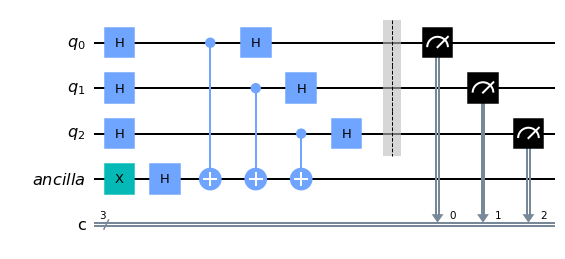

In [165]:
anc = QuantumRegister(1, 'ancilla')


qr = QuantumRegister(3, 'q')
anc = QuantumRegister(1, 'ancilla')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qr, anc, cr)
 
qc.x(anc[0])
qc.h(anc[0])
qc.h(qr[0:3])
qc.cx(qr[0:3], anc[0])
qc.h(qr[0:3])
qc.barrier(qr)
qc.measure(qr, cr)
 
qc.draw('mpl')

In [5]:
def tenToAny(origin, N, n):
    # 10进制转换为n进制list
    list = []
    while True:
        s = origin // n
        tmp = origin % n
        list.append(tmp)
        if s == 0:
            break
        origin = s
    list.reverse()
    list = [str(each) for each in list]
    while len(list) < N:
        list.insert(0,'0')
    return list

In [ ]:
def cyc_determine(m, t_row, t_col, K):
    '''Determine if one binary string can be shifted to another one by m steps
    Args:
        m: index of the basis of the ancilla qudit
        (t_row, t_col): index of element of matrix (in basis of target qubits)
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        value: the value of the element at (t_row, t_col) 
    '''
    # m, t_row, t_col are all decimal integers
    ttt_row = bin(t_row).replace('0b', '') # t'
    ttt_row = ttt_row.zfill(K)
    ttt_col = bin(t_col).replace('0b', '') # t
    ttt_col = ttt_col.zfill(K)

    value = 0
    if ttt_row == ttt_col[m:] + ttt_col[:m]:
        value = 1
    
    return value

def sub_block(m, K):
    '''Get the m-th block matrix of the the matrix representation of the controlled cyclic operator
    Args:
        m: index of the basis of the ancilla qudit
        K: number of bits of the binary expression of t_row and t_col
    Yields:
        block: m-th block matrix
    '''
    block = np.zeros((2**K,2**K))
    for i in range(2**K):
        for j in range(2**K):
            block[i,j] = cyc_determine(m, i, j, K)
            
    return block

def direct_sum(*matrices):
    '''Get the direct sum of all the input square matrices'''
    
    # Get the size of the resulting matrix
    total_size = sum(matrix.shape[0] for matrix in matrices)
    result_matrix = np.zeros((total_size, total_size), dtype=matrices[0].dtype)

    # Populate the block diagonal matrix
    current_row, current_col = 0, 0
    for matrix in matrices:
        size = matrix.shape[0]
        result_matrix[current_row:current_row+size, current_col:current_col+size] = matrix
        current_row += size
        current_col += size

    return result_matrix


# controlled cyclic permutations
def control_cyclic_perm(L, K):
    '''Get the matrix representation of the controlled cyclic operator'''
    
    block_dict = {}

    for m in range(2**L):
        ccc = bin(m).replace('0b', '')
        block_dict[ccc.zfill(L)] = sub_block(m, K)

    return direct_sum(*block_dict.values())

In [10]:
def cyc_determine(m, t_row, t_col, K):
   

    # m, t_row, t_col are all decimal integers

    ttt_row = bin(t_row).replace('0b', '') # t'
    ttt_row = ttt_row.zfill(K)

    ttt_col = bin(t_col).replace('0b', '') # t
    ttt_col = ttt_col.zfill(K)

    value = 0
    if ttt_row == ttt_col[m:] + ttt_col[:m]:
        value = 1
    
    return value


In [7]:
def sub_block(m, K):
    
    block = np.zeros((2**K,2**K))
    for i in range(2**K):
        for j in range(2**K):
            block[i,j] = cyc_determine(m, i, j, K)

    return block


In [11]:
kk = sub_block(2, K)

kk.shape

(8, 8)

In [12]:
def direct_sum(*matrices):
    '''Get the direct sum of all the input square matrices'''
    
    # Get the size of the resulting matrix
    total_size = sum(matrix.shape[0] for matrix in matrices)
    result_matrix = np.zeros((total_size, total_size), dtype=matrices[0].dtype)

    # Populate the block diagonal matrix
    current_row, current_col = 0, 0
    for matrix in matrices:
        size = matrix.shape[0]
        result_matrix[current_row:current_row+size, current_col:current_col+size] = matrix
        current_row += size
        current_col += size

    return result_matrix

# Example usage
A = np.array([[1, 2, 4],
              [3, 4, 4],
              [1, 2, 4]])

B = np.array([[5, 6],
              [7, 8]])

C = np.array([[9, 10],
              [11, 12]])

result = direct_sum(A, B, C)
print(result)


[[ 1  2  4  0  0  0  0]
 [ 3  4  4  0  0  0  0]
 [ 1  2  4  0  0  0  0]
 [ 0  0  0  5  6  0  0]
 [ 0  0  0  7  8  0  0]
 [ 0  0  0  0  0  9 10]
 [ 0  0  0  0  0 11 12]]


In [13]:
# controlled cyclic permutations

def control_cyclic_perm(L, K):
    
    block_dict = {}

    for m in range(2**L):
        ccc = bin(m).replace('0b', '')
        block_dict[ccc.zfill(L)] = sub_block(m, K)

    return direct_sum(*block_dict.values())
    

In [14]:
a = control_cyclic_perm(L, K)
a.shape

(32, 32)

In [24]:
N = 2

circ = QuantumCircuit(2)

mat = np.zeros((2 * 2, 2 * 2))
mat[0, 0] = 1
mat[1, 1] = 1
mat[2, 3] = 1
mat[3, 2] = 1

CNOT = Operator(mat)
circ.rx(math.pi, 0)
circ.append(CNOT, [1,0])

circ.measure_all()

circ.draw()

┌───────┐┌──────────┐ ░ ┌─┐   
   q_0: ┤ Rx(π) ├┤1         ├─░─┤M├───
        └───────┘│  Unitary │ ░ └╥┘┌─┐
   q_1: ─────────┤0         ├─░──╫─┤M├
                 └──────────┘ ░  ║ └╥┘
meas: 2/═════════════════════════╩══╩═
                                 0  1

In [25]:
from qiskit import QuantumCircuit
from qiskit import Aer, execute

backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result().get_counts()
result

{'11': 1}

In [10]:
Uuu

Operator([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
          [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))

In [18]:
state = np.zeros(2**N)
state[-1] = 1

sv = Statevector(state)

dm = DensityMatrix(sv)
dm.measure()

('11111',
 DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                ...,
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 1.+0.j]],
               dims=(2, 2, 2, 2, 2)))

In [57]:
U_ = Operator(circ)
statee = dm.evolve(U_)

In [59]:
statee.measure()

('10',
 DensityMatrix([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
                [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]],
               dims=(2, 2)))

In [16]:
basis(4,0)


Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]

In [3]:
import numpy as np
from qiskit.quantum_info import DensityMatrix

mat = np.zeros((2 * 10, 2 * 10))
mat[0, 0] = 0.5
mat[-1, -1] = 0.5
rho = DensityMatrix(mat, dims=(2, 10))
print(rho.to_dict())

{'00|00': (0.5+0j), '91|91': (0.5+0j)}


In [6]:
import numpy as np
from qiskit.quantum_info import Statevector

vec = np.zeros(2 * 10)
vec[0] = 1 / np.sqrt(2)
vec[-1] = 1 / np.sqrt(2)
psi = Statevector(vec, dims=(2, 10))
print(psi.to_dict())

{'00': (0.7071067811865475+0j), '91': (0.7071067811865475+0j)}


In [1]:
import numpy as np
import math
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import DensityMatrix, Operator, partial_trace, random_density_matrix, random_statevector
N = 6 # Number of qubits
N_meas = 1*2**N  # Number of measurement one perform with one Pauli basis
def meas(qubits_meas_basis, state, N, N_meas):
    ''' Given a Pauli basis (0-Z, 1-X, 2-Y), do measurement and return its outcome
    Args:
        qubits_meas_basis: A list representing measuring basis
        state: A quantum state from Qiskit
        N_meas: see before
    Yeilds:
        outcome: A list of strings, of which each element is an instance of measurement
    E.g.:
        INPUT: [0,0,0], state, N=3, N_meas=2
        OUTPUT: [000, 000] (in order of qubit 012)
    '''
    outcome = []
    circ_meas = QuantumCircuit(N)

    for i in range(N):
        if qubits_meas_basis[i] == '1':
            circ_meas.ry(-math.pi/2,i)
        elif qubits_meas_basis[i] == '2':
            circ_meas.rx(math.pi/2,i)

    U_meas = Operator(circ_meas)
    state_temp = state.evolve(U_meas)
    for j in range(N_meas):
        str_tmp = state_temp.measure()[0]
        outcome.append(str_tmp[::-1])  # Take the reverse

    # Note: in qiskit, qubit number counts from the left, 
    # e.g.: '00101' means we measure qubit0 a '1'.
    return outcome
def number_to_Pauli(pauli_num_str):
    ''' Given a number string, return the corresponding Pauli string
        0-Z, 1-X, 2-Y
    E.g.:
        INPUT: '01200' (in order of qubit 01234)
        OUTPUT: 'ZZYXZ' (in order of qubit 01234)
    '''
    pauli_num_list = list(pauli_num_str)
    pauli_basis_list = list(pauli_num_str)
    for i in range(N):
        if pauli_num_list[i] == '1':
            pauli_basis_list[i] = 'X'
        elif pauli_num_list[i] == '2':
            pauli_basis_list[i] = 'Y'
        else: 
            pauli_basis_list[i] = 'Z'
    return ''.join(pauli_basis_list)
def generate_meas_dataset(state):
    Dict_meas_outcome = dict()
    for i in range(3**N):
        qubits_meas_basis = tenToAny(i,N,3)
        meas_outcome_string = meas(qubits_meas_basis, state, N, N_meas)
        Dict_meas_outcome[number_to_Pauli(''.join(qubits_meas_basis))] = meas_outcome_string
    np.save('measurement_dataset.npy', Dict_meas_outcome)
    return Dict_meas_outcome
def tenToAny(origin,N,n):
    # 10进制转换为n进制list
    list = []
    while True:
        s = origin // n
        tmp = origin % n
        list.append(tmp)
        if s == 0:
            break
        origin = s
    list.reverse()
    list = [str(each) for each in list]
    while len(list) < N:
        list.insert(0,'0')
    return list
def generate_PauliStrList(N):
    ''' Given the number of qubits N, return its corresponding Pauli vector. 
    E.g.:
        INPUT: N=2
        OUTPUT: ['II','IX',...'ZZ']
    '''
    Pauli_str_list = []
    for i in range(4**N):
        pauli_num_list = tenToAny(i,N,4)
        pauli_basis_list = pauli_num_list
        for j in range(N):
            if pauli_num_list[j] == '0':
                pauli_basis_list[j] = 'I'
            elif pauli_num_list[j] == '1':
                pauli_basis_list[j] = 'X' 
            elif pauli_num_list[j] == '2':
                pauli_basis_list[j] = 'Y'
            else: 
                pauli_basis_list[j] = 'Z'
        Pauli_str_list.append(''.join(pauli_basis_list))
        
    return Pauli_str_list
def generate_sub_PauliStrList(PauliStrList, index):
    ''' Given a index (list) of qubits, retrun the Pauli vectors of this sub system.
    E.g.:
        INPUT: PauliStrList=['III',...'ZZZ'], index=[0,2]
        OUTPUT: ['III','IIX','IIY','IIZ','XII','XIX',...'ZIZ']
    '''
    output = list()
    no_meas = list( set(list(range(N))) - set(index) )
    for i in PauliStrList:
        trigger = bool(1)
        for j in no_meas:
            trigger = bool(trigger and i[int(j)]=='I')
        if trigger: output.append(i) 

    return output
def parity_check(meas_string, N_meas):
    ''' Given a measurement outcome binary string array, 
        return 0 if #1 in the string is even, otherwise return 1 for each element
    '''
    meas_parity = np.zeros(N_meas)
    for i in range(N_meas):
        temp = bin(int(meas_string[i],2)).count("1")
        if temp%2 == 0:
            meas_parity[i] = 1
        else:
            meas_parity[i] = -1
    return meas_parity    
def exp_var_calculator(measurement_dataset,pauli_basis_str):
    ''' Given a Pauli basis (on partial qubits, e.g.: XIXZY, IIIXX, ZIIII, etc.) and dataset, 
        return its the applicable measurement outcome expectation value and variance.
    '''
    output = list([])
    for key in measurement_dataset:
        if pauli_basis_str.count('I') == sum(char1 != char2 for char1,char2 in zip(pauli_basis_str,key)):
            output = measurement_dataset[key]+output

    while pauli_basis_str.find('I') != -1:
        index_I = pauli_basis_str.find('I')
        pauli_basis_str = pauli_basis_str[:index_I]+pauli_basis_str[(index_I+1):]
        for j in range(len(output)):
            words = output[j]
            output[j] = words[:index_I]+words[(index_I+1):]

    meas_outcome = parity_check(output,len(output))
    expectation_value = np.average(meas_outcome)
    variance = np.var(meas_outcome)

    return expectation_value, variance
def pauliToMatrix(pauli_str):
    '''Given a Pauli string basis (str), 
       output its corresponding matrix representation (Qobj data).
    '''
    pauli_basis_list = list()
    for basis in pauli_str:
        if basis == 'I':
            pauli_basis_list.append(qeye(2))
        elif basis == 'X':
            pauli_basis_list.append(sigmax())
        elif basis == 'Y':
            pauli_basis_list.append(sigmay())
        else:
            pauli_basis_list.append(sigmaz())
    return tensor(pauli_basis_list)
def q_tomography_dm(qubit_index):
    ''' Do quantum tomography for certain qubits according to the index,
        output the constructed density matrix.
    '''
    density_matrix = 0
    for basis in generate_sub_PauliStrList(PauliStrList, qubit_index):
        expectation, variance = exp_var_calculator(measurement_dataset,basis)
        density_matrix += expectation*pauliToMatrix(basis)
    density_matrix += tensor([qeye(2)]*N)
    return 1/(2**N)*density_matrix.ptrace(qubit_index)  
def q_tomography_vec(qubit_index):
    ''' Do quantum tomography for certain qubits according to the index,
        output a list of expectation value.
    '''
    bloch_vec = []
    for basis in generate_sub_PauliStrList(PauliStrList, qubit_index):
        expectation, variance = exp_var_calculator(measurement_dataset,basis)
        bloch_vec.append(expectation)
    return bloch_vec
def sigma_list(qubit_index):
    output = []
    for basis in generate_sub_PauliStrList(PauliStrList, qubit_index):
        expectation, variance = exp_var_calculator(measurement_dataset,basis)
        sigma = np.power(variance,0.5)
        output.append(sigma)
    return output
def Bloch_vec(qiskit_state, qubit_index):
    ''' Given a qiskit quantum state and the qubit index,
        return the Bloch vector of the reduced state according to the index
    '''
    output = []
    for basis in generate_sub_PauliStrList(PauliStrList, qubit_index):
        output.append(qiskit_state.expectation_value(oper=Pauli(basis), qargs=None))
    return output
def qubit_swap(N,state_43210):
    circSWAP = QuantumCircuit(N)
    for i in range(int(N/2)):
        circSWAP.swap(i,N-1-i)
    U_SWAP = Operator(circSWAP)
    state_01234 = state_43210.evolve(U_SWAP)
    return state_01234

In [ ]:
import qiskit


In [2]:
state_to_learn = random_statevector(2**N)
np.save('q_state.npy', qubit_swap(N,state_to_learn))
measurement_dataset = generate_meas_dataset(state_to_learn)

In [ ]:
state_to_learn = qubit_swap(N,random_density_matrix(2**N))
np.save('q_state.npy', state_to_learn)
measurement_dataset = generate_meas_dataset(state_to_learn)

In [ ]:
DensityMatrix.purity(DensityMatrix(a))

In [ ]:
# Create a Quantum Circuit acting on a quantum register of N qubits
circ = QuantumCircuit(N)
circ.h(0)
circ.h(1)
circ.ry(-math.pi/2,2)
circ.ry(-math.pi/2,3)
#circ.h(4)
#circ.cnot(3,5)
circ.draw('mpl')
U = Operator(circ)

# Set the intial state of the simulator to the ground state using from_int
state = DensityMatrix.from_int(0,2**N)
# Evolve the state by the quantum circuit
state = state.evolve(U)
state_to_learn = qubit_swap(N,state)
#plot_state_city(state)

measurement_dataset = generate_meas_dataset(state)

np.save('q_state.npy', state_to_learn)

In [ ]:
# Create a Quantum Circuit acting on a quantum register of N qubits
circ = QuantumCircuit(N)
circ.h(0)
circ.h(1)
circ.h(2)
#circ.h(3)
#circ.h(4)
circ.draw('mpl')
U = Operator(circ)

state = DensityMatrix.from_int(0,2**N)
# Evolve the state by the quantum circuit
state = state.evolve(U)
state_to_learn = state.copy()

measurement_dataset = generate_meas_dataset(state)

np.save('q_state.npy', state_to_learn)

In [ ]:
# Create a Quantum Circuit acting on a quantum register of N qubits
circ = QuantumCircuit(N)
#circ.rx(math.pi,0)
circ.h(1)
circ.ry(-math.pi/2,2)
#circ.h(1)
#circ.h(2)
#circ.h(3)
#circ.h(4)
circ.draw('mpl')
U = Operator(circ)

state = DensityMatrix.from_int(0,2**N)
# Evolve the state by the quantum circuit
state = state.evolve(U)
#state.measure()

In [ ]:
state

In [ ]:
qubit_swap(N,state)

In [ ]:
measurement_dataset

In [ ]:
state_to_learn

In [ ]:
range(int(7/2))